In [1]:
!pip uninstall torchvision -y
!pip install torchvision==0.8.1
!pip install torch==1.6

Uninstalling torchvision-0.9.1+cu101:
  Successfully uninstalled torchvision-0.9.1+cu101
     |████████████████████████████████| 12.7MB 228kB/s 
     |████████████████████████████████| 776.8MB 23kB/s 
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.7.0 which is incompatible.
  Found existing installation: torch 1.8.1+cu101
    Uninstalling torch-1.8.1+cu101:
      Successfully uninstalled torch-1.8.1+cu101
     |████████████████████████████████| 748.8MB 23kB/s 
ERROR: torchvision 0.8.1 has requirement torch==1.7.0, but you'll have torch 1.6.0 which is incompatible.
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.6.0 which is incompatible.
  Found existing installation: torch 1.7.0
    Uninstalling torch-1.7.0:
      Successfully uninstalled torch-1.7.0


In [2]:
import numpy as np
import matplotlib.pylab as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import time
from torch.autograd import Variable, Function
from torchsummary import summary
from torchvision import transforms, datasets
from torchvision.datasets import VisionDataset, ImageFolder
import matplotlib.pyplot as plt
import itertools
import math
from torch.nn.modules.utils import _pair

In [3]:
BATCH_SIZE = 100

In [4]:
transform = transforms.Compose([
  transforms.Resize(50),
  transforms.CenterCrop(50),
  transforms.ToTensor()
])

In [5]:
# train_data = torchvision.datasets.Caltech101(
#     root = './',
#     transform = transform,
#     download=True
# )

In [6]:
caltech_data = datasets.ImageFolder("./caltech101/101_ObjectCategories/", transform=transform)
caltech_data_size = len(caltech_data)
train_data_size = int(0.7 * caltech_data_size)
val_data_size = (caltech_data_size - train_data_size)//2
test_data_size = caltech_data_size - train_data_size - val_data_size

In [7]:
NUM_CLASSES = len(caltech_data.classes)

In [8]:
torch.manual_seed(42)
train_data, val_test_data = torch.utils.data.random_split(caltech_data, [train_data_size, caltech_data_size-train_data_size])
val_data, test_data = torch.utils.data.random_split(val_test_data, [val_data_size, test_data_size])

In [9]:
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, drop_last=True)
val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [10]:
def validate(model, args):
    criterion = nn.CrossEntropyLoss()
    total = 0
    for i, (xs, ys) in enumerate(test_dataloader):
        images, labels = get_torch_vars(xs, ys, args.gpu)
        outputs = model(images)
        predict = torch.argmax(outputs, dim=1)
        total += torch.sum(labels == predict)
    return total.item() / (len(test_dataloader) * BATCH_SIZE)

In [11]:
def get_torch_vars(xs, ys, gpu=False):
    """
    Helper function to convert numpy arrays to pytorch tensors.
    If GPU is used, move the tensors to GPU.

    Args:
      xs (float numpy tenosor): greyscale input
      ys (int numpy tenosor): categorical labels
      gpu (bool): whether to move pytorch tensor to GPU
    Returns:
      Variable(xs), Variable(ys)
    """
    if gpu:
        xs = xs.cuda()
        ys = ys.cuda()
    return Variable(xs), Variable(ys)

In [12]:
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

def train(model, args):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate)
    print("Beginning training ...")
    if args.gpu:
        model.cuda()
    start = time.time()
    # print(1)
    train_losses = []
    valid_accs = []
    for epoch in range(args.epochs):
        # Train the Model
        model.train()  # Change model to 'train' mode
        losses = []
        # print(1)
        for i, (xs, ys) in enumerate(train_dataloader):
            images, labels = get_torch_vars(xs, ys, args.gpu)
            # Forward + Backward + Optimize
            # print(labels)
            # print(images.size())
            optimizer.zero_grad()
            outputs = model(images)

            # print(outputs.view(BATCH_SIZE, NUM_CLASSES))

            loss = criterion(outputs.view(BATCH_SIZE, NUM_CLASSES), labels)
            print("i:", i, "loss:", loss)
            loss.backward()
            optimizer.step()
            losses.append(loss.data.item())
        avg_loss = np.mean(losses)
        train_losses.append(avg_loss)
        time_elapsed = time.time() - start
        print(
            "Epoch [%d/%d], Loss: %.4f, Time (s): %d"
            % (epoch + 1, args.epochs, avg_loss, time_elapsed)
        )
        model.eval()
        val_acc = validate(model, args)
        valid_accs.append(val_acc)
        print(
            "Epoch [%d/%d], Validation Accuracy: %.4f"
            % (epoch + 1, args.epochs, val_acc)
        )
    return model, train_losses, valid_accs

In [13]:
class SpectralPooling2d(nn.Module):
    def __init__(self, kernel_size):
        super(SpectralPooling2d, self).__init__()

        self.kernel_size = 2

    def crop_spectrum(self, z, H, W):
        '''
            z: [bs, c, M, N, 2]
            Return: [bs, c, H, H, 2]
        '''
        M, N = z.size(-3), z.size(-2)
        topleft = z[..., :M//2-H//2+1, :N//2-W//2+1, :]
        topright = z[..., :M//2-H//2+1, N//2+W//2:, :]
        bottomleft = z[..., M//2+H//2:, :N//2-W//2+1, :]
        bottomright = z[...,M//2+H//2:, N//2+W//2:, :]
        top = torch.cat((topleft, topright), dim=3)
        bottom = torch.cat((bottomleft, bottomright), dim=3)

        return torch.cat((top, bottom),dim=2)


        #return z[..., M//2-H//2:M//2+H//2, N//2-W//2:N//2+W//2, :]

    def pad_spectrum(self, z, M, N):
        '''
            z: [bs, c, H, W, 2]
            Return: [bs, c, M, N, 2]
        '''
        H, W = z.size(-3), z.size(-2)
        z_real, z_imag = z[..., 0], z[..., 1]
        pad = torch.nn.ZeroPad2d((N-W)//2, (N-W)//2, (M-H)//2, (M-H)//2)
        print(z_real.size(), z_imag.size())
        return torch.stack([pad(z_real), pad(z_imag)], dim = -1)

    def treat_corner_cases(self, freq_map):
        '''
            freq_map: [bs, c, M, N, 2]
        '''
        S = [(0, 0)]
        M, N = freq_map.size(-3), freq_map.size(-2)

        if M % 2 == 1:
            S.append((M // 2, 0))
        if N % 2 == 1:
            S.append((0, N // 2))
        if M % 2 == 1 and N % 2 == 1:
            S.append((M // 2, N // 2))

        for h, w in S:
            freq_map[..., h, w, 1].zero_()

        return freq_map, S

    def remove_redundancy(self, y):
        '''
            y: input gradient map [bs, c, M, N, 2]
        '''
        z, S = self.treat_corner_cases(y)
        I = []
        M, N = y.size(-3), y.size(-2)

        for m in range(M):
            for n in range(N // 2 + 1):
                if (m, n) not in S:
                    if (m, n) not in I:
                        z[..., m, n, :].mul_(2)
                        I.append((m, n))
                        I.append(((M - m) % M, (N - n) % N))
                    else:
                        z[..., m, n, :].zero_()
        
        return z

    def recover_map(self, y):
        z, S = self.treat_corner_cases(y)
        I = []
        M, N = y.size(-3), y.size(-2)

        for m in range(M):
            for n in range(N // 2 + 1):
                if (m, n) not in S:
                    if (m, n) not in I:
                        z[..., m, n, :].mul_(0.5)
                        z[..., (M-m)%M, (N-n)%N] = z[..., m, n, :]
                        I.append((m, n))
                        I.append(((M - m) % M, (N - n) % N))
                    else:
                        z[..., m, n, :].zero_()

        return z

    def forward(self, x):
        M, N = x.size(-2), x.size(-1)
        H, W = M // self.kernel_size, N // self.kernel_size

        x_fft = torch.rfft(x, 2, onesided = False)
        crop_x_fft = self.crop_spectrum(x_fft, H, W)
        crop_x_fft, _ = self.treat_corner_cases(crop_x_fft)
        pool_x = torch.irfft(crop_x_fft, 2, onesided = False)
        return pool_x

    def backward(self, gRgx):
        H, W = gRgx.size(-2), gRgx.size(-1)
        M, N = H * self.kernel_size, W * self.kernel_size

        z = torch.rfft(gRgx, 2, onesided = False)
        z = self.remove_redundancy(z)
        z = self.pad_spectrum(z, M, N)
        z = self.recover_map(z)
        gRx = torch.irfft(z, 2, onesided = False)

        return gRx

In [14]:
class GaussianPooling2d(nn.AvgPool2d):
    def __init__(self, num_features, kernel_size, stride=None, padding=0, ceil_mode=False,
                 count_include_pad=True, hidden_node=None, stochasticity='HWCN', eps=1e-6):
        if stochasticity != 'HWCN' and stochasticity != 'CN' and stochasticity is not None:
            raise ValueError("gaussian pooling stochasticity has to be 'HWCN'/'CN' or None, "
                         "but got {}".format(stochasticity))
        if hidden_node is None:
            hidden_node = num_features // 2

        super(GaussianPooling2d, self).__init__(kernel_size, stride=stride, padding=padding, ceil_mode=ceil_mode,
                    count_include_pad=count_include_pad)
        self.eps = eps
        self.stochasticity = stochasticity

        self.ToHidden = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Conv2d(num_features, hidden_node, kernel_size=1,  padding=0, bias=True),
            nn.BatchNorm2d(hidden_node),
            nn.ReLU(False),
        )
        self.ToMean = nn.Sequential(
            nn.Conv2d(hidden_node, num_features, kernel_size=1,  padding=0, bias=True),
            nn.BatchNorm2d(num_features),
        )
        self.ToSigma = nn.Sequential(
            nn.Conv2d(hidden_node, num_features, kernel_size=1,  padding=0, bias=True),
            nn.BatchNorm2d(num_features),
            nn.Sigmoid()
        )
        self.activation = nn.Softplus()
        
    def forward(self, input):
        mu0 = F.avg_pool2d(input, self.kernel_size, self.stride, self.padding, self.ceil_mode, self.count_include_pad)
        sig0= F.avg_pool2d(input**2, self.kernel_size, self.stride, self.padding, self.ceil_mode, self.count_include_pad)
        sig0= torch.sqrt(torch.clamp(sig0 - mu0**2, self.eps))

        Z = self.ToHidden(input)
        MU = self.ToMean(Z)

        if self.training and self.stochasticity is not None:
            SIGMA = self.ToSigma(Z)
            if self.stochasticity == 'HWCN':
                size = sig0.size()
            else:
                size = [sig0.size(0), sig0.size(1), 1, 1]
            W = self.activation(MU + SIGMA * 
                torch.randn(size, dtype=sig0.dtype, layout=sig0.layout, device=sig0.device))
        else:
            W = self.activation(MU)

        return mu0 + W*sig0

In [15]:
spectral_model = torch.hub.load('pytorch/vision:v0.8.1', 'vgg16', pretrained=False)

Downloading: "https://github.com/pytorch/vision/archive/v0.8.1.zip" to /root/.cache/torch/hub/v0.8.1.zip


In [16]:
spectral_model.features[4] =  SpectralPooling2d(0.5).cuda()
spectral_model.features[9] = SpectralPooling2d(0.5).cuda()
spectral_model.features[16] = SpectralPooling2d(0.5).cuda()
spectral_model.features[23] = SpectralPooling2d(0.5).cuda()
spectral_model.features[30] = SpectralPooling2d(0.5).cuda()
spectral_model.classifier[6] = nn.Linear(4096, NUM_CLASSES).cuda()

In [17]:
args = AttrDict()
torch.cuda.empty_cache()
spectral_model.cuda()
args_dict = {
    "gpu": True,
    "epochs": 50,
    "learning_rate": 1e-4
}
args.update(args_dict)
final_model_spectral, train_losses_spectral, valid_accs_spectral = train(spectral_model, args)

Beginning training ...
i: 0 loss: tensor(5.7850, device='cuda:0', grad_fn=<NllLossBackward>)
i: 1 loss: tensor(4.6024, device='cuda:0', grad_fn=<NllLossBackward>)
i: 2 loss: tensor(4.5529, device='cuda:0', grad_fn=<NllLossBackward>)
i: 3 loss: tensor(4.3414, device='cuda:0', grad_fn=<NllLossBackward>)
i: 4 loss: tensor(4.3545, device='cuda:0', grad_fn=<NllLossBackward>)
i: 5 loss: tensor(4.1594, device='cuda:0', grad_fn=<NllLossBackward>)
i: 6 loss: tensor(4.1940, device='cuda:0', grad_fn=<NllLossBackward>)
i: 7 loss: tensor(4.2323, device='cuda:0', grad_fn=<NllLossBackward>)
i: 8 loss: tensor(4.2901, device='cuda:0', grad_fn=<NllLossBackward>)
i: 9 loss: tensor(4.2560, device='cuda:0', grad_fn=<NllLossBackward>)
i: 10 loss: tensor(4.1521, device='cuda:0', grad_fn=<NllLossBackward>)
i: 11 loss: tensor(4.3415, device='cuda:0', grad_fn=<NllLossBackward>)
i: 12 loss: tensor(4.1568, device='cuda:0', grad_fn=<NllLossBackward>)
i: 13 loss: tensor(4.2827, device='cuda:0', grad_fn=<NllLossBack

In [18]:
gaussian_model = torch.hub.load('pytorch/vision:v0.8.1', 'vgg16', pretrained=False)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.8.1


In [19]:
gaussian_model.features[4] =  GaussianPooling2d(64,2,2).cuda()
gaussian_model.features[9] = GaussianPooling2d(128,2,2).cuda()
gaussian_model.features[16] = GaussianPooling2d(256,2,2).cuda()
gaussian_model.features[23] = GaussianPooling2d(512,2,2).cuda()
gaussian_model.features[30] = GaussianPooling2d(512,2,2).cuda()
gaussian_model.classifier[6] = nn.Linear(4096, NUM_CLASSES).cuda()

In [20]:
args = AttrDict()
torch.cuda.empty_cache()
args_dict = {
    "gpu": True,
    "epochs": 50,
    "learning_rate": 1e-4
}
args.update(args_dict)
final_model_gaussian, train_losses_gaussian, valid_accs_gaussian = train(gaussian_model, args)

Beginning training ...
i: 0 loss: tensor(4.6284, device='cuda:0', grad_fn=<NllLossBackward>)
i: 1 loss: tensor(4.6049, device='cuda:0', grad_fn=<NllLossBackward>)
i: 2 loss: tensor(4.5221, device='cuda:0', grad_fn=<NllLossBackward>)
i: 3 loss: tensor(4.4190, device='cuda:0', grad_fn=<NllLossBackward>)
i: 4 loss: tensor(4.6310, device='cuda:0', grad_fn=<NllLossBackward>)
i: 5 loss: tensor(4.3817, device='cuda:0', grad_fn=<NllLossBackward>)
i: 6 loss: tensor(4.4148, device='cuda:0', grad_fn=<NllLossBackward>)
i: 7 loss: tensor(4.3940, device='cuda:0', grad_fn=<NllLossBackward>)
i: 8 loss: tensor(4.4225, device='cuda:0', grad_fn=<NllLossBackward>)
i: 9 loss: tensor(4.4073, device='cuda:0', grad_fn=<NllLossBackward>)
i: 10 loss: tensor(4.4153, device='cuda:0', grad_fn=<NllLossBackward>)
i: 11 loss: tensor(4.4392, device='cuda:0', grad_fn=<NllLossBackward>)
i: 12 loss: tensor(4.3970, device='cuda:0', grad_fn=<NllLossBackward>)
i: 13 loss: tensor(4.4186, device='cuda:0', grad_fn=<NllLossBack

In [21]:
vgg_model = torch.hub.load('pytorch/vision:v0.8.1', 'vgg16', pretrained=False)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.8.1


In [22]:
vgg_model.classifier[6] = nn.Linear(4096, NUM_CLASSES).cuda()

In [23]:
args = AttrDict()
torch.cuda.empty_cache()
vgg_model.cuda()
args_dict = {
    "gpu": True,
    "epochs": 50,
    "learning_rate": 1e-4
}
args.update(args_dict)
final_model_max, train_losses_max, valid_accs_max = train(vgg_model, args)

Beginning training ...
i: 0 loss: tensor(4.6290, device='cuda:0', grad_fn=<NllLossBackward>)
i: 1 loss: tensor(4.5949, device='cuda:0', grad_fn=<NllLossBackward>)
i: 2 loss: tensor(4.4806, device='cuda:0', grad_fn=<NllLossBackward>)
i: 3 loss: tensor(4.1297, device='cuda:0', grad_fn=<NllLossBackward>)
i: 4 loss: tensor(5.4442, device='cuda:0', grad_fn=<NllLossBackward>)
i: 5 loss: tensor(4.4098, device='cuda:0', grad_fn=<NllLossBackward>)
i: 6 loss: tensor(4.4270, device='cuda:0', grad_fn=<NllLossBackward>)
i: 7 loss: tensor(4.5060, device='cuda:0', grad_fn=<NllLossBackward>)
i: 8 loss: tensor(4.5123, device='cuda:0', grad_fn=<NllLossBackward>)
i: 9 loss: tensor(4.5743, device='cuda:0', grad_fn=<NllLossBackward>)
i: 10 loss: tensor(4.5690, device='cuda:0', grad_fn=<NllLossBackward>)
i: 11 loss: tensor(4.5715, device='cuda:0', grad_fn=<NllLossBackward>)
i: 12 loss: tensor(4.5889, device='cuda:0', grad_fn=<NllLossBackward>)
i: 13 loss: tensor(4.5652, device='cuda:0', grad_fn=<NllLossBack

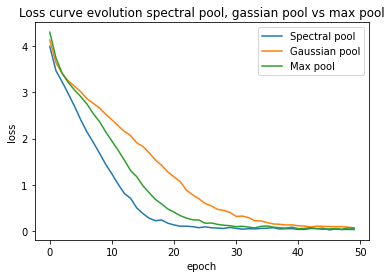

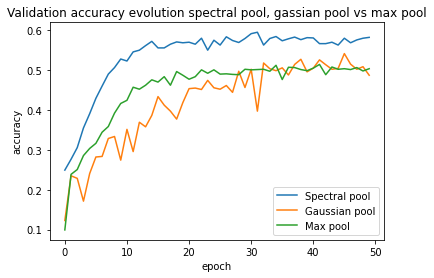

In [24]:
epochs_arr = np.arange(0, args_dict['epochs'])

plt.plot(epochs_arr, train_losses_spectral, label='Spectral pool')
plt.plot(epochs_arr, train_losses_gaussian, label='Gaussian pool')
plt.plot(epochs_arr, train_losses_max, label='Max pool')
plt.title('Loss curve evolution spectral pool, gassian pool vs max pool')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

plt.plot(epochs_arr, valid_accs_spectral, label='Spectral pool')
plt.plot(epochs_arr, valid_accs_gaussian, label='Gaussian pool')
plt.plot(epochs_arr, valid_accs_max, label='Max pool')
plt.title('Validation accuracy evolution spectral pool, gassian pool vs max pool')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [25]:
# save models
torch.save(spectral_model.state_dict(), 'spectral_model.pt')
torch.save(gaussian_model.state_dict(), 'gaussian_model.pt')
torch.save(vgg_model.state_dict(), 'vgg_model.pt')

In [26]:
print('Minimnum training loss for spectral pool model', min(train_losses_spectral))
print('Minimnum training loss for gaussian pool model', min(train_losses_gaussian))
print('Minimnum training loss for max pool model', min(train_losses_max))

Minimnum training loss for spectral pool model 0.03385263781819958
Minimnum training loss for gaussian pool model 0.07559075400786242
Minimnum training loss for max pool model 0.046383887325646356


In [27]:
print('Maximum validation accuracy for spectral pool model', max(valid_accs_spectral))
print('Maximum validation accuracy for gaussian pool model', max(valid_accs_gaussian))
print('Maximum validation accuracy for max pool model', max(valid_accs_max))

Maximum validation accuracy for spectral pool model 0.595
Maximum validation accuracy for gaussian pool model 0.5414285714285715
Maximum validation accuracy for max pool model 0.5142857142857142
